In [1]:
import timeit

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ejecutar esta línea si pymoo no ha sido instalado
# %pip install -U pymoo

In [2]:
# Demanda
DEMANDA = 60
# Costo por unidad de tiempo
CTIEMPO = 100
# Tiempo máximo definido
T_MAX = 360
# Parámetros de entrada
params_df = pd.read_excel('./data/' + 'nuevo_info_acopios.xlsx')
# Matriz de costos de transporte
trans_cost_df = pd.read_excel('./data/' + 'costoTransporteCAi.xlsx', index_col=0)
# Matriz de tiempos de transporte
trans_time_df = pd.read_excel('./data/' + 'tiempoTransporteCAi.xlsx', index_col=0)

In [3]:
# Número de centros de acopio
N = params_df.shape[0]

# Vector de representación
CAPACIDADES = np.empty(N*2, dtype=float)

# Capacidades en stock y potencial por centro de acopio
for cap_i in range(0, N*2, 2):
    CAPACIDADES[cap_i] = params_df['Stock'].iloc[cap_i//2]
    CAPACIDADES[cap_i+1] = params_df['Ppotencial'].iloc[cap_i//2]

CAPACIDADES = np.append(CAPACIDADES, N-1)

In [4]:
def get_delta(x, i, idx_acopio, idx_principal=-1):
    kca = x[i] + x[i + 1]
    precio = params_df['Precio'].iloc[idx_acopio]
    talistam = 0

    if x[i + 1]:
        talistam = params_df['TiempoAlistam'].iloc[idx_acopio]

    ' Si es el centro de acopio principal (idx_principal=-1) '
    if idx_principal < 0:
        ctransp = params_df['Ctransp'].iloc[idx_acopio]
        ttransp = params_df['TiempoTransp'].iloc[idx_acopio]
        tiempo = talistam + ttransp

        return (kca * precio) + ctransp + (tiempo * CTIEMPO)
    else:
        ctransp = trans_cost_df.iloc[idx_acopio, idx_principal]
        ttransp = trans_time_df.iloc[idx_acopio, idx_principal]
        tiempo = talistam + ttransp

        return (kca * precio) + ctransp + (tiempo * CTIEMPO)

In [5]:
def f(x):
    delta = 0
    idx_principal = int(x[N*2])

    for i in range(0, N*2, 2):
        idx_acopio = i//2

        if x[i] == 0 and x[i+1] == 0:
            continue

        if idx_acopio == idx_principal:
            # Única suma de kCAp
            delta += get_delta(x, i, idx_acopio)
            continue

        # Sumas con kCAi
        delta += get_delta(x, i, idx_acopio, idx_principal)

    return delta

In [6]:
def balance(individual, delta, diff):
    delta = np.squeeze(delta)

    # Reducir para igualar a la demanda
    if diff:
        acopios = list(np.nonzero(individual)[0])

        while delta > 0 and len(acopios) > 0:
            idx = np.random.choice(acopios)
            acopios.remove(idx)

            if delta <= individual[idx]:
                individual[idx] -= delta
                delta = 0
            else:
                delta -= individual[idx]
                individual[idx] = 0
    # Aumentar para igualar a la demanda
    else:
        acopios = list(np.where(individual == 0)[0])

        while delta > 0 and len(acopios) > 0:
            idx = np.random.choice(acopios)
            acopios.remove(idx)

            if delta <= CAPACIDADES[idx]:
                individual[idx] = delta
                delta = 0
            else:
                individual[idx] = CAPACIDADES[idx]
                delta -= CAPACIDADES[idx]

# Algoritmo Genético (pymoo)

Definición del modelo de optimización

In [7]:
from pymoo.core.problem import ElementwiseProblem

xl = np.zeros(CAPACIDADES.shape[0])
xu = CAPACIDADES


class Queso(ElementwiseProblem):
    def __init__(self):
        super().__init__(
            n_var=len(xl),
            n_obj=1,
            n_eq_constr=1,
            # n_ieq_constr=1,
            xl=xl,
            xu=xu
        )

    def _evaluate(self, x, out, *args, **kwargs):
        out['F'] = f(x)
        # Se retira el último elemento del vector (centro de acopio principal), 
        # para validar la restricción de igualdad
        individual = np.delete(x, N * 2)
        out['H'] = DEMANDA - np.sum(individual)


model = Queso()

## Generación 
De nuevas posibles soluciones

In [8]:
from pymoo.core.sampling import Sampling


class TopOrZeroSampling(Sampling):
    def _do(self, problem, n_samples, **kwargs):
        gen_matrix = np.zeros((n_samples, problem.n_var), dtype=float)
        # Se indexan los centros de acopio
        n_vars = problem.n_var

        for i in range(n_samples):
            # Se reorganizan todos los índices de los centros de acopio, de forma aleatoria
            indices = np.arange(n_vars - 1)
            np.random.shuffle(indices)

            while np.sum(gen_matrix[i]) < DEMANDA and indices.size > 0:
                idx = indices[0]
                gen_matrix[i, idx] += CAPACIDADES[idx]
                indices = np.delete(indices, 0)

                if np.sum(gen_matrix[i]) > DEMANDA:
                    gen_matrix[i, idx] = gen_matrix[i, idx] - (np.sum(gen_matrix[i]) - DEMANDA)
                    break

            gen_matrix[i, N * 2] = np.random.randint(CAPACIDADES[N * 2] + 1)

        return gen_matrix

## Cruce

Implementación de cruce en un punto

In [9]:
from pymoo.core.crossover import Crossover

class SinglePointCross(Crossover):
    def __init__(self, prob):
        # Para la implementación personalizada de este método, se consideraron 2 padres,
        # entonces cambiar los valores de la llamada a init no tendrá efecto.
        # Lo mismo pasa con el único offspring.
        super().__init__(n_parents=2, n_offsprings=1, prob=prob)

    def _do(self, problem, X, **kwargs):
        # n_parents, n_matings, n_var
        _, n_matings, n_var = X.shape

        T = np.zeros((1, n_matings, n_var))
        Y = np.full_like(T, None, dtype=float)

        for idx in range(n_matings):

            # Primera mitad
            p1 = X[0, idx, : n_var//2]
            # Segunda mitad
            p2 = X[1, idx, n_var//2 : n_var - 1]

            offspring = np.concatenate((p1, p2))

            if np.sum(offspring) > DEMANDA:
                delta = np.sum(offspring) - DEMANDA
                balance(offspring, delta, True)
            else:
                delta = DEMANDA - np.sum(offspring)
                balance(offspring, delta, False)

            for i in range(offspring.shape[0]):
                Y[0, idx, i] = offspring[i]

            # Centro de acopio principal (última posición)
            main = np.random.choice([X[0, idx, n_var-1], X[1, idx, n_var-1]])
            Y[0, idx, n_var-1] = main

        return Y

## Mutación
Con una probabilidad dada, reasignar la cantidad asignada a un centro de acopio **o**, reasignar el centro de acopio principal.

In [10]:
from pymoo.core.mutation import Mutation

class ReassignMutation(Mutation):
    def __init__(self, prob):
        super().__init__()
        self.prob = prob

    def _do(self, problem, X, **kwargs):
        for i in range(len(X)):
            r = np.random.random()

            if r < self.prob:
                # Se toma un índice aleatorio
                individual = X[i]
                idx_mut = np.random.randint(individual.shape)

                # Si es el índice del centro de acopio principal (N*2)
                if idx_mut == N*2:
                    X[i, problem.n_var-1] = np.random.randint(CAPACIDADES[N*2] + 1)

                else:
                    if individual[idx_mut] == 0:
                        # Se asigna la máxima cantidad posible del índice
                        delta = CAPACIDADES[idx_mut]
                        individual[idx_mut] = CAPACIDADES[idx_mut]
                        diff = True
                    else:
                        # Se asigna cero a la cantidad del índice
                        delta = individual[idx_mut]
                        individual[idx_mut] = 0
                        diff = False

                    balance(individual, delta, diff)

                    for j in range(individual.shape[0]):
                        X[i, j] = individual[j]

        return X

## Aplicación

In [11]:
' Algoritmo genético '

# Probabilidad de cruce
p_cross = 0.8
# Probabilidad de mutación
p_mutate = 0.9
# Tamaño de la población
pop_size = 100
# Máximo número de generaciones
max_gen = 1000
# Máximo número de llamados a la función objetivo
max_evals = 100000

Definición del algoritmo genético


In [12]:
from pymoo.algorithms.soo.nonconvex.ga import GA

algorithm = GA(
    pop_size=pop_size,
    sampling=TopOrZeroSampling(),
    crossover=SinglePointCross(prob=p_cross),
    mutation=ReassignMutation(prob=p_mutate),
    eliminate_duplicates=True
)


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False



Criterio de terminación: https://pymoo.org/interface/termination.html

In [13]:
# Criterios simples
# from pymoo.termination import get_termination

# termination = get_termination('n_eval', 1000)
# termination = get_termination('n_gen', 50)
# termination = get_termination('time', '00:00:03')

from pymoo.termination.default import DefaultSingleObjectiveTermination

termination = DefaultSingleObjectiveTermination(
    # Definición de tolerancia para lo que se 
    # considera una solución diferente
    xtol=1e-8,
    cvtol=1e-6,
    ftol=1e-6,
    # Número de iteraciones antes de finalizar 
    # al no encontrar una mejor solución
    period=100,
    # Máximo de generaciones 
    n_max_gen=max_gen,
    # Máximo de evaluaciones de función objetivo
    n_max_evals=max_evals
)

Optimización y resultados

In [14]:
from pymoo.optimize import minimize

t_start_ga = timeit.default_timer()
ga = minimize(model, algorithm, termination, seed=1, save_history=True, verbose=False)
t_end_ga = timeit.default_timer()

t_delta_ga = t_end_ga - t_start_ga

# print_acopios(res.X)
print(f'Centro de acopio principal: {params_df['Id_CA'].iloc[int(ga.X[N * 2])]}')
print(f'Precio: {ga.F}')
print(f'Tiempo: {round(t_delta_ga * 1000)}ms, ({t_delta_ga})')

Centro de acopio principal: CA2
Precio: [392608.]
Tiempo: 15997ms, (15.997141500003636)


In [15]:
rep = pd.DataFrame(np.repeat(params_df, [2], axis=0))[0].rename('CAcopio')
rep.loc[rep.reset_index().index % 2 == 0] = rep + ' Stock'
rep.loc[rep.reset_index().index % 2 == 1] = rep + ' Potencial'
rep = rep.reset_index()
rep.insert(2, 'Capacidad', np.delete(CAPACIDADES, N*2))
rep.insert(3, 'Asignada', np.delete(ga.X, N * 2))
rep

,index,CAcopio,Capacidad,Asignada
0,0,CA1 Stock,10.000,10.000
1,1,CA1 Potencial,0.500,0.500
2,2,CA2 Stock,12.000,12.000
3,3,CA2 Potencial,0.625,0.625
4,4,CA3 Stock,4.000,0.000
5,5,CA3 Potencial,14.000,0.000
6,6,CA4 Stock,8.000,8.000
7,7,CA4 Potencial,13.000,13.000
8,8,CA5 Stock,18.000,0.000
9,9,CA5 Potencial,15.000,0.000


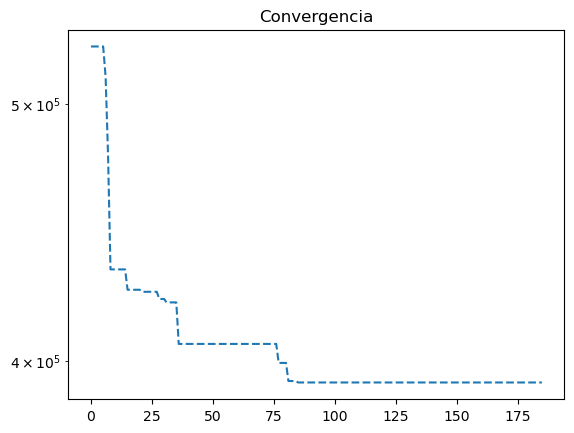

In [16]:
n_evals = np.array([e.evaluator.n_eval for e in ga.history])
opt = np.array([e.opt[0].F for e in ga.history])
gen_evals = np.arange(opt.shape[0])

plt.title('Convergencia')
plt.plot(gen_evals, opt, '--')
plt.yscale('log')
plt.show()